In [2]:
import numpy as np
import matplotlib.pyplot as plt
import DataUtilities

# 1.1 - Utility Functions

In [3]:
def getSensors(measurementData, time, sensor_index, codeDict):
    """Gets all sensor readings for a given time step"""
    z_t = np.zeros(shape=(0,3))
    
    # Check index is within bounds
    if (sensor_index >= measurementData.shape[0]):
        return z_t, sensor_index
    
    # Keep incrementing index
    while(measurementData[sensor_index,0] - time < 0.005):
        z_code = measurementData[sensor_index,1]
        z_range = measurementData[sensor_index,2]
        z_bearing = measurementData[sensor_index,3]
        
        landmarkID = 0;
        if (z_code in codeDict):
            landmarkID = codeDict[z_code]
        else:
            continue
        
        if ((landmarkID > 5) and (landmarkID < 21)):
            z_new = [z_range, z_bearing, landmarkID]
            z_t = np.vstack([z_t, z_new])
        sensor_index += 1
        
        if (sensor_index >= measurementData.shape[0]):
            return z_t, sensor_index
        
    return z_t, sensor_index

# 1.2 - EKF Class

In [4]:
class LandmarkNoCorr_EKF():
    def __init__(self):
        self._map = None
        self._state = None
        self._var = None
        self._alphas = None
        self._Q = None
    
    @property
    def state(self):
        return self._state.T[0]
    
    def initState(self, x, y, theta):
        self._state= np.array([[x], [y], [theta]])
        
    def initStateCovariance(self, x_var, y_var, theta_var):
        self._var = np.diag([x_var, y_var, theta_var])
    
    def initInputCovariance(self, v_var, w_var):
        self._Q = np.diag([v_var, w_var])
        
    def initAlphas(self, alphas):
        self.alphas = alphas
    
    def initLandmarks(self, landmarks):
        self._map = landmarks
    
    def correctAngle(self, angle):
        """Corrects an angle to be in [-pi, pi]"""
        while(angle < -np.pi):
            angle = angle + 2*np.pi
        while(angle > np.pi):
            angle = angle - 2*np.pi
        return angle
    
    def motionStep(self, v, w, dT):
        """Run the motion step to update pose and covariance with odometry"""
        # Used for calcs
        theta = self.state[2]
        C_t = np.cos(theta + 0.5*w*dT)
        S_t = np.sin(theta + 0.5*w*dT)

        # Calculate matrices
        G = np.array([[1, 0, -1*v*dT*S_t],
                      [0, 1, v*dT*C_t],
                      [0, 0, 1]])
        
        M = np.array([[(self.alphas[0]*abs(v) + self.alphas[1]*abs(w))**2, 0],
                      [0, (self.alphas[2]*abs(v) + self.alphas[3]*abs(w))**2]])
        
        V = np.array([[C_t, -0.5*S_t],
                      [S_t, 0.5*C_t],
                      [0, 1]])

        # Pose update
        d_state = np.array([[v*dT*C_t],
                            [v*dT*S_t],
                            [dT*w]])
        self._state = self._state + d_state
        self._state[2,0] = self.correctAngle(self._state[2,0])
        
        # Covariance update
        self._var = (G @ self._var @ G.T) + (V @ M @ V.T)
    
    def sensorStep(self, z_range, z_bearing):
        """Run the sensor model for a single sensor hit"""
        # Setup vars
        z_t = np.array([z_range, z_bearing])
        num_landmarks = self._map.shape[0]
        # Stores z_exp, S, and H matrices for the optim problem
        predZ = np.zeros(shape=(num_landmarks, 1, 2))
        predS = np.zeros(shape=(num_landmarks, 2, 2))
        predH = np.zeros(shape=(num_landmarks, 2, 3))
        # Optim problem vars
        maxJ = 0
        landmarkIndex = 0
        for j in range(num_landmarks):
            xDist = self._map[j,1] - self.state[0]
            yDist = self._map[j,2] - self.state[1]
            q = xDist**2 + yDist**2;

            # Calculate z_exp, H, and S
            predZ[j,:,:] = [np.sqrt(q),
                            self.correctAngle(np.arctan2(yDist, xDist) - self.state[2])]

            predH[j,:,:] = [[-xDist/np.sqrt(q), -yDist/np.sqrt(q), 0],
                            [yDist/q, -xDist/q, -1]]

            H_temp = np.squeeze(predH[j,:,:])
            predS[j,:,:] = (H_temp @ self._var @ H_temp.T) + self._Q

            S_temp = np.squeeze(predS[j,:,:])
            Z_temp = np.squeeze(predZ[j,:,:])
            
            # Check if better
            exp_temp = np.exp(-0.5*(z_t - Z_temp).T @ np.linalg.inv(S_temp) @ (z_t - Z_temp))
            J = np.linalg.det(2*np.pi*S_temp)**(-0.5) * exp_temp
            if (J > maxJ):
                maxJ = J
                landmarkIndex = j

        # Compute matrices
        H_temp = np.squeeze(predH[landmarkIndex,:,:])
        S_temp = np.squeeze(predS[landmarkIndex,:,:])
        Z_temp = np.squeeze(predZ[landmarkIndex,:,:])
        K = self._var @ H_temp.T @ np.linalg.inv(S_temp)
        
        # Update state
        self._state = self._state + np.expand_dims(K @ (z_t - Z_temp), axis=1)
        self._state[2,0] = self.correctAngle(self._state[2,0])
        
        # Update covariance
        self._var = (np.eye(3) - (K @ H_temp)) @ self._var
    
        

# 1.3 - Load Data

In [5]:
# Robot data
truth_data = np.genfromtxt("Data/robot_groundtruth.csv", delimiter=",")
odom_data = np.genfromtxt("Data/robot_odometry.csv", delimiter=",")
meas_data = np.genfromtxt("Data/robot_measurement.csv", delimiter=",")

# Landmark data
landmark_data = DataUtilities.loadFile("Data\MRCLAM_Dataset1\Landmark_Groundtruth.dat")
bar_dict = DataUtilities.createBarcodeDict("Data\MRCLAM_Dataset1\Barcodes.dat")

# 1.4 - Run EKF

In [6]:
dT = 0.02

# Setup EKF
ekf = LandmarkNoCorr_EKF()
# Intialize initial state
ekf.initState(truth_data[0,1], truth_data[0,2], truth_data[0,3])
# Initialize covariance matrices and movement uncertainties
ekf.initStateCovariance(0.01, 0.01, 0.01)
ekf.initInputCovariance(0.1849, 0.36)
ekf.initAlphas([0.2, 0.03, 0.09, 0.08])
# Initialize landmark map
ekf.initLandmarks(landmark_data)

# Get sensor index up to a reasonable position
sensor_index = 0
while(meas_data[sensor_index][0] < odom_data[0][0] - 0.05):
    sensor_index += 1

# Run EKF
ekf_data = np.empty(shape=(0,4))
for i, odom in enumerate(odom_data):
    # Motion model
    time, v, w = odom_data[i,:]
    ekf.motionStep(v, w, dT)
    
    # Sensor model
    z_t, sensor_index = getSensors(meas_data, time, sensor_index, bar_dict)
    for j in range(len(z_t)):
        z_range = z_t[j,0]
        z_bearing = z_t[j,1]
        ekf.sensorStep(z_range, z_bearing)

    # Save EKF state
    curr_state = ekf.state
    ekf_data = np.vstack([ekf_data, [time, curr_state[0], curr_state[1], curr_state[2]]])

# 1.5 - Plot Path

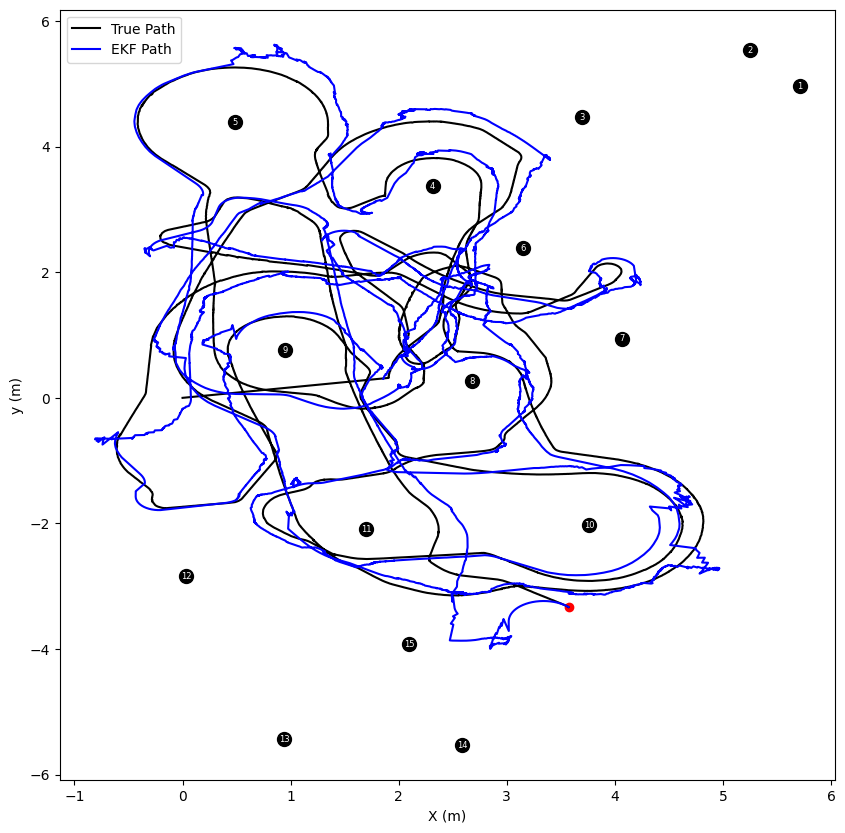

In [7]:
plt.figure(figsize=(10,10))
# Plot true path
plt.plot(truth_data[:,1], truth_data[:,2], c='black', label="True Path")
plt.scatter(truth_data[0,1], truth_data[0,2], c="red")
# Plot EKF path
plt.plot(ekf_data[:,1], ekf_data[:,2], c="blue", label="EKF Path")
# Plot landmarks
plt.scatter(landmark_data[:,1], landmark_data[:,2], c='black', s=100)
for i, landmark in enumerate(landmark_data):
    plt.text(landmark[1], landmark[2], i+1, c="white", ha="center", va="center", fontsize=6)
# Setup and plot
plt.xlabel("X (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

# 1.7 - Errors

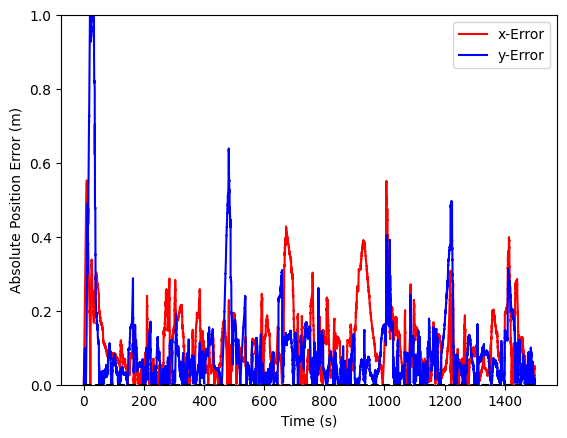

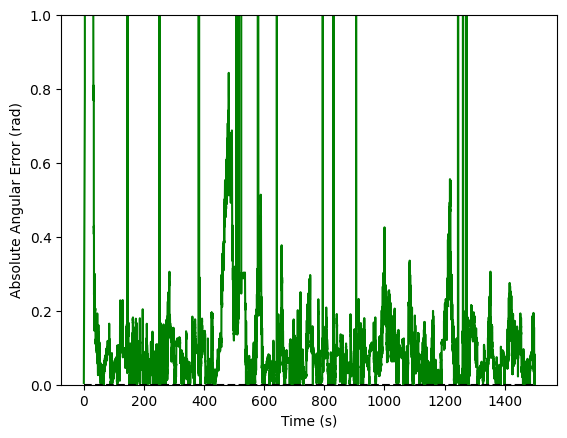

In [9]:
start = 0
# Position error
plt.figure()
time = truth_data[start:,0]
x_error = abs(ekf_data[:,1] - truth_data[start:,1])
y_error = abs(ekf_data[:,2] - truth_data[start:,2])
offset = 1
plt.plot(time[:-offset], x_error[:-offset], c='red', label="x-Error")
plt.plot(time[:-offset], y_error[:-offset], c='blue', label="y-Error")
plt.hlines(0, truth_data[0,0], truth_data[-1,0], colors='black', ls="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Absolute Position Error (m)")
plt.ylim([0,1])
plt.show()

# Angular error
plt.figure()
time = truth_data[start:,0]
theta_error = abs(ekf_data[:,3] - truth_data[start:,3])
offset = 1
plt.plot(time[:-offset], theta_error[:-offset], c='green')
plt.hlines(0, truth_data[0,0], truth_data[-1,0], colors='black', ls="--")
plt.xlabel("Time (s)")
plt.ylabel("Absolute Angular Error (rad)")
plt.ylim([0,1])
plt.show()